In [398]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
import seaborn
from matplotlib.lines import Line2D
from astropy.cosmology import Planck18
plt.rc("font", family="serif")
plt.rc("text", usetex=True)
import warnings
warnings.filterwarnings('ignore')
import astropy.coordinates as coord
import astropy.units as u
import corner
import seaborn as sns

### Read in simulation files

In [356]:
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=2_batch001.pkl', 'rb') as f:
    doubles = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_NEW_large_numimages=4_batch001.pkl', 'rb') as f:
    quads = pickle.load(f)
with open('../processed_data/Baseline_v_3_0/Baselinev30_unlensed_gband_batch001.pkl', 'rb') as f:
    sne = pickle.load(f)
    
print("Doubles: ", len(doubles))
print("Quads: ", len(quads))
print("Unlensed: ", len(sne))

Doubles:  5000
Quads:  5000
Unlensed:  5000


### Read in sumstat files from Suhail

In [22]:
print("Columns: SNID  Npremax Nfilt obs_start   theta_E     mB      dt_input")

sumstat_doubles = np.genfromtxt('../processed_data/sumstat_earlydet_doubles.txt',
                  dtype=['U15', np.float, np.float, np.float, np.float, np.float, np.float])[1:]
sumstat_quads = np.genfromtxt('../processed_data/sumstat_earlydet_quads.txt',
                  dtype=['U15', np.float, np.float, np.float, np.float, np.float, np.float])[1:]

sumstat_d, sumstat_q = [], []

for s in range(len(sumstat_quads)):
    
    if s < len(sumstat_doubles):
        d = sumstat_doubles[s]
        d_row = np.array([float(d[0][2:]), d[1], d[2], d[3], d[4], d[5], d[6]])
        sumstat_d.append(d_row)
    
    q = sumstat_quads[s]
    q_row = np.array([float(q[0][2:]), q[1], q[2], q[3], q[4], q[5], q[6]])
    sumstat_q.append(q_row)
    
sumstat_d = np.array(sumstat_d)
sumstat_q = np.array(sumstat_q)

print("Doubles: ", np.shape(sumstat_d))
print("Quads: ", np.shape(sumstat_q))

Columns: SNID  Npremax Nfilt obs_start   theta_E     mB      dt_input
Doubles:  (1896, 7)
Quads:  (2953, 7)


### Compute detected sample

In [92]:
dt_doubles, dt_quads = [], []
mutot_doubles, mutot_quads = [], []
peak_i_doubles, peak_i_quads = [], []
peak_r_doubles, peak_r_quads = [], []
peak_z_doubles, peak_z_quads = [], []
peak_y_doubles, peak_y_quads = [], []

for s in range(len(doubles)):
    
    dt_doubles.append(doubles['time_delay'][s][1])
    dt_quads.append(max(quads['time_delay'][s]))
    mutot_doubles.append(np.sum(doubles['macro_mag'][s]))
    mutot_quads.append(np.sum(quads['macro_mag'][s]))
    peak_r_doubles.append(doubles['peak_magnitudes_micro'][s][1])
    peak_r_quads.append(quads['peak_magnitudes_micro'][s][1])
    peak_i_doubles.append(doubles['peak_magnitudes_micro'][s][2])
    peak_i_quads.append(quads['peak_magnitudes_micro'][s][2])
    peak_z_doubles.append(doubles['peak_magnitudes_micro'][s][3])
    peak_z_quads.append(quads['peak_magnitudes_micro'][s][3])
    peak_y_doubles.append(doubles['peak_magnitudes_micro'][s][4])
    peak_y_quads.append(quads['peak_magnitudes_micro'][s][4])
    
dt_doubles = np.array(dt_doubles)
dt_quads = np.array(dt_quads)
mutot_doubles = np.array(mutot_doubles)
mutot_quads = np.array(mutot_quads)
peak_r_doubles = np.array(peak_r_doubles)
peak_r_quads = np.array(peak_r_quads)
peak_i_doubles = np.array(peak_i_doubles)
peak_i_quads = np.array(peak_i_quads)
peak_z_doubles = np.array(peak_z_doubles)
peak_z_quads = np.array(peak_z_quads)
peak_y_doubles = np.array(peak_y_doubles)
peak_y_quads = np.array(peak_y_quads)

In [604]:
# masks

# Rolling / non-rolling
md_nonrol = (doubles['obs_start']) <= 60768
md_rol = (doubles['obs_start']) > 60768
mq_nonrol = (quads['obs_start']) <= 60768
mq_rol = (quads['obs_start']) > 60768

# Survey
md_WFD = (doubles['survey']) == 'WFD'
md_DDF = (doubles['survey']) == 'DDF'
md_gal = (doubles['survey']) == 'galactic plane'
mq_WFD = (quads['survey']) == 'WFD'
mq_DDF = (quads['survey']) == 'DDF'
mq_gal = (quads['survey']) == 'galactic plane'

# Detected
md_detected = (doubles['mag_method'] == True) | (doubles['mult_method'] == True)
md_detected_micro = (doubles['mag_method_micro'] == True) | (doubles['mult_method_micro'] == True)
md_detected_peak = (doubles['mag_method_peak'] == True) | (doubles['mult_method_peak'] == True)
md_nondetect_micro = (doubles['mag_method_micro'] == False) & (doubles['mult_method_micro'] == False)
md_nondetect = (doubles['mag_method'] == False) & (doubles['mult_method'] == False)
mq_detected_micro = (quads['mag_method_micro'] == True) | (quads['mult_method_micro'] == True)
mq_detected = (quads['mag_method'] == True) | (quads['mult_method'] == True)
mq_nondetect_micro = (quads['mag_method_micro'] == False) & (quads['mult_method_micro'] == False)
mq_nondetect = (quads['mag_method'] == False) & (quads['mult_method'] == False)
mq_detected_peak = (quads['mag_method_peak'] == True) | (quads['mult_method_peak'] == True)

md_mult_peak = (doubles['mult_method_peak'] == True)
md_mag_peak = (doubles['mag_method_peak'] == True)
mq_mult_peak = (quads['mult_method_peak'] == True)
mq_mag_peak = (quads['mag_method_peak'] == True)

# Minimum time delay
dt_lim = 10
md_dt_lim = dt_doubles > dt_lim
mq_dt_lim = dt_quads > dt_lim

md_thetaE = doubles['theta_E'] > 0.5
mq_thetaE = quads['theta_E'] > 0.5

print("Doubles: ", md_detected_micro.sum())
print("Quads: ", mq_detected_micro.sum())

Doubles:  2057
Quads:  3462


## Compute detected Sumstat lists

In [52]:
sumstat_d_detect = []
sumstat_q_detect = []

for i in range(len(sumstat_d)):
    # If in detected sample
    if md_detected_micro[int(sumstat_d[i][0])]:
        sumstat_d_detect.append(sumstat_d[i])
        
for j in range(len(sumstat_q)):
    # If in detected sample
    if mq_detected_micro[int(sumstat_q[j][0])]:
        sumstat_q_detect.append(sumstat_q[j])

sumstat_d_detect = np.array(sumstat_d_detect)
sumstat_q_detect = np.array(sumstat_q_detect)

print("Doubles: ", np.shape(sumstat_d_detect))
print("Quads: ", np.shape(sumstat_q_detect))

Doubles:  (1237, 7)
Quads:  (2723, 7)


In [208]:
sumstat_d_detect[:,2]

array([4., 4., 4., ..., 3., 3., 3.])

In [211]:
# New list for N_early: if no information assume zero 
# (then there aren't even enough points to get a decent peak estimate, so probably useless anyway)
# Also save list with True False if in gold sample

Nearly_d, Nearly_q = [], []
sumstat_indices_d = np.array([int(x) for x in sumstat_d_detect[:,0]])
sumstat_indices_q = np.array([int(x) for x in sumstat_q_detect[:,0]])
gold_d, gold_q = [], []

for i in range(len(doubles)):
    # --------------------------------------------------
    # Doubles
    goldsample_doubles = False
    # In detected sample
    if md_detected_micro[i]:
        # In sumstat list
        if i in sumstat_indices_d:
            index = np.where(sumstat_indices_d == i)[0][0]
            Nearly_d.append(sumstat_d_detect[index, 1])
            
            # For gold sample: 
            if sumstat_d_detect[index, 1] > 5:
                if sumstat_d_detect[index, 2] > 1:
                    if peak_i_doubles[i] < 22.5:
                        if dt_doubles[i] > 10:
                            # Passed!
                            goldsample_doubles = True
        else:
            Nearly_d.append(0.0)
            
    if goldsample_doubles:
        gold_d.append(True)
    else:
        gold_d.append(False)
    
    # --------------------------------------------------
    # Quads
    goldsample_quads = False
    # In detected sample
    if mq_detected_micro[i]:
        # In sumstat list
        if i in sumstat_indices_q:
            index = np.where(sumstat_indices_q == i)[0][0]
            Nearly_q.append(sumstat_q_detect[index, 1])
            
            # For gold sample: 
            if sumstat_q_detect[index, 1] > 5:
                if sumstat_q_detect[index, 2] > 1:
                    if peak_i_quads[i] < 22.5:
                        if dt_quads[i] > 10:
                            # Passed!
                            goldsample_quads = True
        else:
            Nearly_q.append(0.0)
            
    if goldsample_quads:
        gold_q.append(True)
    else:
        gold_q.append(False) 
    # --------------------------------------------------
            
Nearly_d = np.array(Nearly_d)
Nearly_q = np.array(Nearly_q)
gold_d = np.array(gold_d)
gold_q = np.array(gold_q)

print("Doubles: ", np.shape(Nearly_d), len(gold_d), gold_d.sum())
print("Quads: ", np.shape(Nearly_q), len(gold_q), gold_q.sum())

Doubles:  (2057,) 5000 454
Quads:  (3462,) 5000 780


### Summary properties of detected sample

Only sample that has N_premax measurement


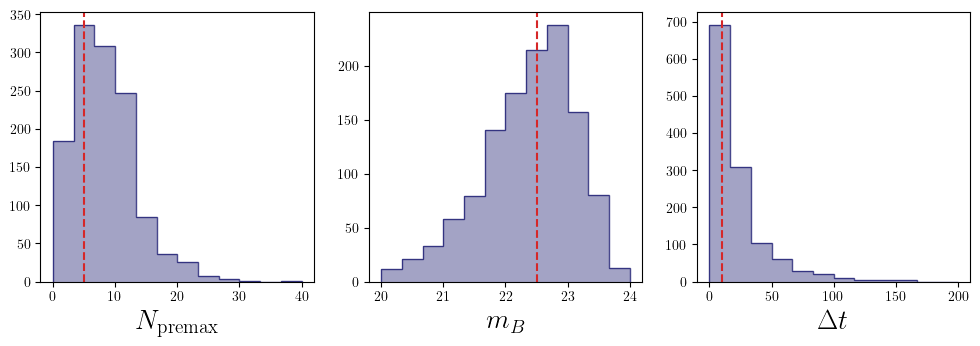

In [57]:
print("Only sample that has N_premax measurement")

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

properties = [sumstat_d_detect[:,1], sumstat_d_detect[:,5], sumstat_d_detect[:,6]]
ranges = [(0, 40), (20, 24), (0, 200)]
labels = [r'$N_{\rm premax}$', r'$m_B$', r'$\Delta t$']
limits = [5, 22.5, 10]
bins=12

for i in range(3):
    ax[i].hist(properties[i], range=ranges[i], alpha=0.4, color='Midnightblue', bins=bins)
    ax[i].hist(properties[i], range=ranges[i], alpha=0.8, color='Midnightblue', histtype='step',  bins=bins)
    ax[i].axvline(x=limits[i], color='C3', ls='--')
    ax[i].set_xlabel(labels[i], fontsize=20)
    
#plt.savefig("../Results/Figures/Results_0506/Goldsample.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

Differences between image mult. and mag. method
5000


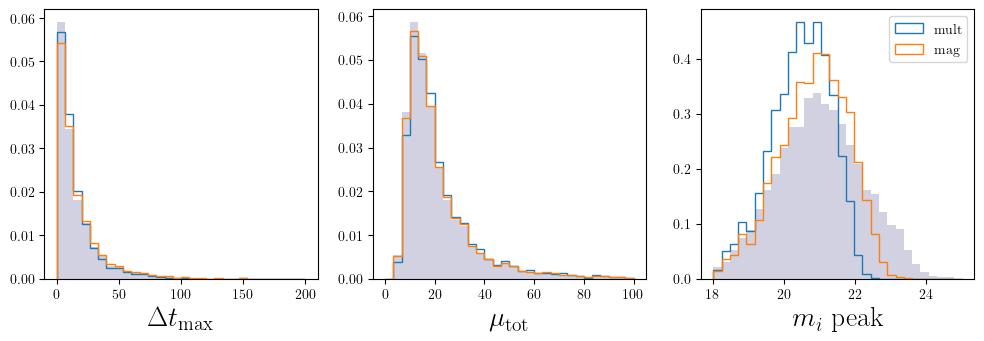

In [101]:
print("Differences between image mult. and mag. method")
print(len(peak_i_doubles))

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

properties_d = [dt_doubles, mutot_doubles, peak_i_doubles]
properties_d_mult = [dt_doubles[md_mult_peak], mutot_doubles[md_mult_peak], peak_y_doubles[md_mult_peak]]
properties_d_mag = [dt_doubles[md_mag_peak], mutot_doubles[md_mag_peak], peak_y_doubles[md_mag_peak]]
properties_q = [dt_quads, mutot_quads, peak_i_quads]
properties_q_mult = [dt_quads[mq_mult_peak], mutot_quads[mq_mult_peak], peak_y_quads[mq_mult_peak]]
properties_q_mag = [dt_quads[mq_mag_peak], mutot_quads[mq_mag_peak], peak_y_quads[mq_mag_peak]]
ranges = [(0, 200), (0, 100), (18, 25)]
labels = [r'$\Delta t_{\rm max}$', r'$\mu_{\rm tot}$', r'$m_i$ peak']
bins=30

for i in range(3):
    ax[i].hist(properties_q[i], range=ranges[i], alpha=0.2, color='Midnightblue', bins=bins, density=True)
    ax[i].hist(properties_q_mult[i], range=ranges[i], histtype='step', bins=bins, density=True, label='mult')
    ax[i].hist(properties_q_mag[i], range=ranges[i], histtype='step', bins=bins, density=True, label='mag')
    ax[i].set_xlabel(labels[i], fontsize=20)
plt.legend()
#plt.savefig("../Results/Figures/Results_0506/Goldsample.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

# Observation: the image multiplicty method seems to deliver objects that are brighter than the mag method.
# This is strange. Hypothesis: most objects pass the detection threshold in the z or y-bands, 
# but are fainter in the i and r bands. So they appear to be too faint for detection in those bluer bands.
# However, z and y observations are more scarce. And for the image multiplicity method you need more of those 
# observations if the images have a time delay between their peaks, so this is less likely to happen,
# and instead they need to rely more on r and i detections, requiring them to be brighter in those bands.
# (and then they're also brighter in z and y)
# Note: this cannot explain the distributions at peak though! (no cadence taken into account...)

In [80]:
doubles['peak_magnitudes_micro'][0]

array([        nan, 27.46716137, 24.35101979, 23.69091417, 23.24480178])

Figure shows that the peak magnitudes are brightest in the redder (z and y) bands


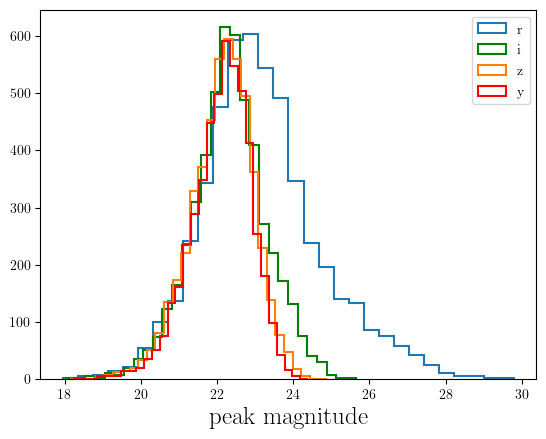

In [90]:
print("Figure shows that the peak magnitudes are brightest in the redder (z and y) bands")
plt.figure()
plt.hist(peak_r_doubles, bins=30, histtype='step', lw=1.5, color='C0', label='r')
plt.hist(peak_i_doubles, bins=30, histtype='step', lw=1.5, color='green', label='i')
plt.hist(peak_z_doubles, bins=30, histtype='step', lw=1.5, color='C1', label='z')
plt.hist(peak_y_doubles, bins=30, histtype='step', lw=1.5, color='red', label='y')
plt.xlabel('peak magnitude', fontsize=18)
plt.legend()

plt.show()

Differences between doubles and quads (detected sample)


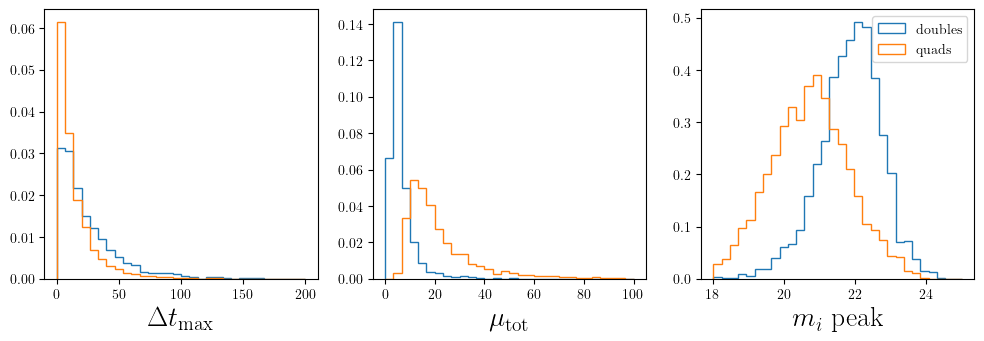

In [120]:
print("Differences between doubles and quads (detected sample)")

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

properties_d = [dt_doubles[md_detected_micro], mutot_doubles[md_detected_micro], peak_i_doubles[md_detected_micro]]
properties_q = [dt_quads[mq_detected_micro], mutot_quads[mq_detected_micro], peak_i_quads[mq_detected_micro]]
ranges = [(0, 200), (0, 100), (18, 25)]
labels = [r'$\Delta t_{\rm max}$', r'$\mu_{\rm tot}$', r'$m_i$ peak']
bins=30

for i in range(3):
    ax[i].hist(properties_d[i], range=ranges[i], histtype='step', bins=bins, density=True, label='doubles')
    ax[i].hist(properties_q[i], range=ranges[i], histtype='step', bins=bins, density=True, label='quads')
    ax[i].set_xlabel(labels[i], fontsize=20)
plt.legend()
#plt.savefig("../Results/Figures/Results_0506/Goldsample.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')


### Figure 9 from the paper

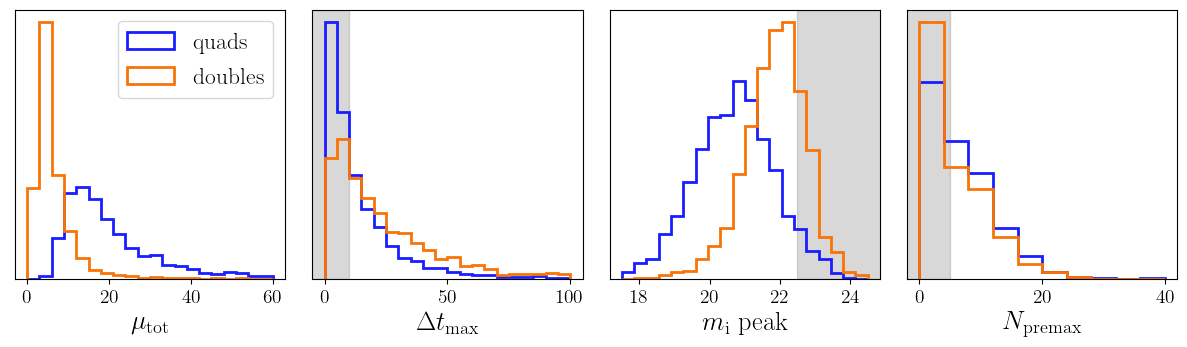

In [743]:

fig, ax = plt.subplots(1, 4, figsize=(15, 3.5))
fig.subplots_adjust(wspace=0.1)

properties_d = [mutot_doubles[md_detected_micro], dt_doubles[md_detected_micro], 
                peak_i_doubles[md_detected_micro], Nearly_d]
properties_q = [mutot_quads[mq_detected_micro], dt_quads[mq_detected_micro], 
                peak_i_quads[mq_detected_micro], Nearly_q]
ranges = [(0, 60), (0, 100), (17.5, 24.5), (0, 40)]
labels = [r'$\mu_{\rm tot}$', r'$\Delta t_{\rm max}$', r'$m_{\rm i}$ peak', r'$N_{\rm premax}$']
bins = [20, 20, 20, 10]
limits = [np.nan, 10, 22.5, 5]
fill = [np.nan, [-50, 10], [22.5, 25], [-5, 5]]
#doubles:00b899 quads:7d42b8

for i in range(4):
    ax[i].hist(properties_q[i], range=ranges[i], histtype='step', lw=2, bins=bins[i], density=True, 
               label='quads',  color='#191dff')
    ax[i].hist(properties_d[i], range=ranges[i], histtype='step', lw=2, bins=bins[i], density=True, 
               label='doubles', color='#f87408')
    ax[i].set_xlabel(labels[i], fontsize=19)
    ax[i].xaxis.set_tick_params(labelsize=14)
    ax[i].set_yticks([])
    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
    
    if not np.isnan(limits[i]):
        #ax[i].axvline(x=limits[i], color='C3', ls='--')
        ax[i].fill_between(fill[i], ymin, ymax, color='gray', alpha=0.3)
        
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(ymin, ymax)

ax[0].legend(fontsize=17)
plt.savefig("../Results/Figures/Results_0506/Properties_detected.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')


### Number of detected gold sample per year

In [624]:
print("WFD (based on simple scaling 20,000 >> 18,000)")
print(" ")

# Yearly predicted rates by Wojtak et al.

rates_total = 89 * 3
fraction_quads = 0.28
fraction_doubles = 0.72
rates_quads = rates_total * fraction_quads
rates_doubles = rates_total * fraction_doubles

sd2 = rates_doubles / ((md_WFD) & (md_detected_peak)).sum() / 1.5 /20000 * 18000
sq2 = rates_quads / ((mq_WFD) & (mq_detected_peak)).sum() / 1.5 /20000 * 18000

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((md_WFD) & (md_detected_peak) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_peak) & (md_rol)).sum()*sd2)
print("N detected  :     ",  ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N detected micro: ",  ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("dt > 10 :         ",  ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("Gold sample :     ",  ((gold_d) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((gold_d) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("dt 1 day no micro:",  ((dt_gg_d) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((dt_gg_d) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("dt 5% no micro:   ",  ((dt_g_d) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((dt_g_d) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("dt 1 day micro:   ",  ((dt_gg_d_micro) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((dt_gg_d_micro) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("dt 5% micro:      ",  ((dt_g_d_micro) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((dt_g_d_micro) & (md_thetaE) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)

print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((mq_WFD) & (mq_detected_peak) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_peak) & (mq_rol)).sum()*sq2)
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2)
print("N detected micro: ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("dt > 10           ",  ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("Gold sample :     ",  ((gold_q) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((gold_q) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("dt 1 day no micro ",  ((dt_gg_q) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((dt_gg_q) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("dt 5% no micro    ",  ((dt_g_q) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((dt_g_q) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("dt 1 day micro    ",  ((dt_gg_q_micro) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((dt_gg_q_micro) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("dt 5% micro:      ",  ((dt_g_q_micro) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((dt_g_q_micro) & (mq_thetaE) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)

print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("without microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected)).sum()*sd2 + ((mq_WFD) & (mq_detected)).sum()*sq2)/2)
print(" ")

print("with microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("N in Gold sample  : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (gold_q)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (gold_d)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (gold_q)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (gold_d)).sum()*sd2)


print(" ")
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected_micro)).sum()*sd2 + ((mq_WFD) & (mq_detected_micro)).sum()*sq2)/2)

WFD (based on simple scaling 20,000 >> 18,000)
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected peak:   58.098946994373705      57.245053005626296
N detected  :      35.48783417234232      30.979273911755996
N detected micro:  32.27719277465206      27.187984601717503
dt > 10 :          21.723063073734085      18.444110156944035
Gold sample :      8.197382291975126      6.318815516730826
dt 1 day no micro: 0.37571335504885994      0.44402487414865266
dt 5% no micro:    0.853893988747409      0.7855824696476162
dt 1 day micro:    0.478180633698549      0.1707787977494818
dt 5% micro:       0.7514267100977199      0.6831151909979272
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected peak:   22.385625910931175      22.470374089068827
N detected  :      18.24507206477733      17.252307692307692
N detected micro:  17.39759028340081      16.27165020242915
dt > 10            7.893687449392713      7.772618623481782
Gold sample :      4.673256680161944

In [646]:
print(len(doubles[(gold_d) & (md_WFD) & (md_detected_micro)]) / len(doubles[(md_WFD) & (md_detected_micro)]) * 100)
print(len(quads[(gold_q) & (mq_WFD) & (mq_detected_micro)]) / len(quads[(mq_WFD) & (mq_detected_micro)]) * 100)

24.41125789775991
25.49442646530025


### Time-delay estimates from LSST-only data

In [528]:
dt_d = np.loadtxt('../processed_data/time_delay_measurements/summary_timedelay_noMicro_doubles.txt')
dt_d_micro = np.loadtxt('../processed_data/time_delay_measurements/summary_timedelay_withMicro_doubles.txt')
dt_q = np.loadtxt('../processed_data/time_delay_measurements/summary_timedelay_noMicro_quad.txt')
dt_q_micro = np.loadtxt('../processed_data/time_delay_measurements/summary_timedelay_withMicro_quad.txt')

print(np.shape(dt_q_micro))

print(dt_q[0])

(2001, 3)
[ 4.23300000e+03 -4.08454806e+00  4.21355096e-02]


In [632]:
dt_gg_d = np.zeros(len(doubles))
dt_g_d = np.zeros(len(doubles))
dt_gg_d_micro = np.zeros(len(doubles))
dt_g_d_micro = np.zeros(len(doubles))
dt_d_true, dt_d_est = [], []

for i in range(len(dt_d)):
    indexx = int(dt_d[i][0])
    
    dt_d_est.append(abs(dt_d[i][1]))
    dt_d_true.append(dt_doubles[indexx])
    
    if abs(abs(dt_d[i][1]) - dt_doubles[indexx]) < 1:
        if abs(dt_d[i][2] < 0.5):
            dt_gg_d[indexx] = 1.0
            
    if abs(abs(dt_d[i][1]) - dt_doubles[indexx])/dt_doubles[indexx] < 0.05:
        dt_g_d[indexx] = 1.0
    # print(int(dt_d[i][0]), abs(dt_d[i][1]), dt_doubles[int(dt_d[i][0])], dt_g_d[indexx])
    
for i in range(len(dt_d_micro)):
    indexx = int(dt_d_micro[i][0])
    if abs(abs(dt_d_micro[i][1]) - dt_doubles[indexx]) < 1:
        if abs(dt_d_micro[i][2] < 0.5):
            dt_gg_d_micro[indexx] = 1.0
            
    if abs(abs(dt_d_micro[i][1]) - dt_doubles[indexx])/dt_doubles[indexx] < 0.05:
        dt_g_d_micro[indexx] = 1.0
        
dt_d_true = np.array(dt_d_true)
dt_d_est = np.array(dt_d_est)

dt_gg_d = dt_gg_d.astype(np.bool)
dt_g_d = dt_g_d.astype(np.bool)
dt_gg_d_micro = dt_gg_d_micro.astype(np.bool)
dt_g_d_micro = dt_g_d_micro.astype(np.bool)
    
print("Doubles, no micro: ", dt_gg_d.sum(), dt_g_d.sum())
print("Doubles,    micro: ", dt_gg_d_micro.sum(), dt_g_d_micro.sum())

Doubles, no micro:  56 59
Doubles,    micro:  31 40


In [633]:
dt_gg_q = np.zeros(len(quads))
dt_g_q = np.zeros(len(quads))
dt_gg_q_micro = np.zeros(len(quads))
dt_g_q_micro = np.zeros(len(quads))
dt_q_true, dt_q_est = [], []
dt_q_true_gg, dt_q_est_gg = [], []
dt_q_true_g, dt_q_est_g = [], []

for i in range(len(dt_q)):
    indexx = int(dt_q[i][0])
    
    dt_q_est.append(abs(dt_q[i][1]))
    dt_q_true.append(dt_quads[indexx])
    
    if abs(abs(dt_q[i][1]) - dt_quads[indexx]) < 1:
        if abs(dt_q[i][2] < 0.5):
            dt_gg_q[indexx] = 1.0
            dt_q_est_gg.append(abs(dt_q[i][1]))
            dt_q_true_gg.append(dt_quads[indexx])
            
    if abs(abs(dt_q[i][1]) - dt_quads[indexx])/dt_quads[indexx] < 0.05:
        dt_g_q[indexx] = 1.0
        dt_q_est_g.append(abs(dt_q[i][1]))
        dt_q_true_g.append(dt_quads[indexx])
    
for i in range(len(dt_q_micro)):
    indexx = int(dt_q_micro[i][0])
    if abs(abs(dt_q_micro[i][1]) - dt_quads[indexx]) < 1:
        if abs(dt_q_micro[i][2] < 0.5):
            dt_gg_q_micro[indexx] = 1.0
            
    if abs(abs(dt_q_micro[i][1]) - dt_quads[indexx])/dt_quads[indexx] < 0.05:
        dt_g_q_micro[indexx] = 1.0
    
print("Quads, no micro: ", dt_gg_q.sum(), dt_g_q.sum())
print("Quads,    micro: ", dt_gg_q_micro.sum(), dt_g_q_micro.sum())

dt_q_true = np.array(dt_q_true)
dt_q_est = np.array(dt_q_est)
dt_q_true_gg = np.array(dt_q_true_gg)
dt_q_est_gg = np.array(dt_q_est_gg)
dt_q_true_g = np.array(dt_q_true_g)
dt_q_est_g = np.array(dt_q_est_g)

dt_gg_q = dt_gg_q.astype(np.bool)
dt_g_q = dt_g_q.astype(np.bool)
dt_gg_q_micro = dt_gg_q_micro.astype(np.bool)
dt_g_q_micro = dt_g_q_micro.astype(np.bool)

Quads, no micro:  239.0 68.0
Quads,    micro:  226.0 61.0


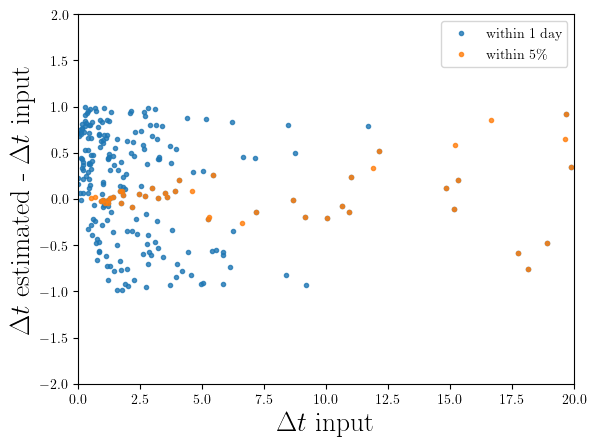

In [594]:
#plt.plot(dt_q_est, dt_q_true - dt_q_est, '.', alpha=0.4, label='all')
plt.plot(dt_q_est_gg, dt_q_true_gg - dt_q_est_gg, '.', alpha=0.8, label='within 1 day')
plt.plot(dt_q_est_g, dt_q_true_g - dt_q_est_g, '.', alpha=0.8, label=r'within $5\%$')
plt.xlim(0, 20)
plt.ylim(-2, 2)
plt.xlabel(r"$\Delta t$ input", fontsize=20)
plt.ylabel(r"$\Delta t$ estimated - $\Delta t$ input", fontsize=20)
plt.legend()
#plt.savefig("../Results/Figures/Results_0506/Timedelay_estimates.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

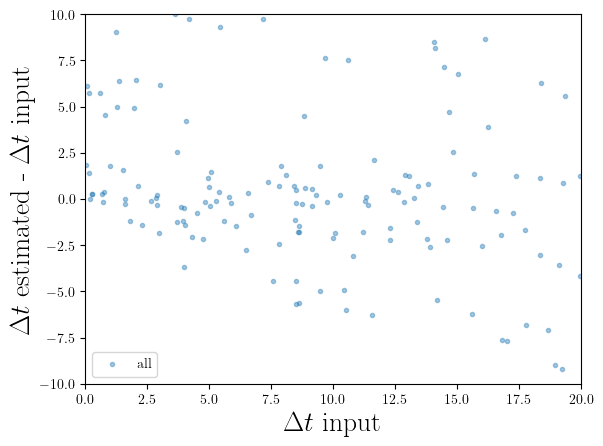

In [592]:
plt.plot(dt_d_est, dt_d_true - dt_d_est, '.', alpha=0.4, label='all')
#plt.plot(dt_q_est_gg, dt_q_true_gg - dt_q_est_gg, '.', alpha=0.8, label='within 1 day')
#plt.plot(dt_q_est_g, dt_q_true_g - dt_q_est_g, '.', alpha=0.8, label=r'within $5\%$')
plt.xlim(0, 20)
plt.ylim(-10, 10)
plt.xlabel(r"$\Delta t$ input", fontsize=20)
plt.ylabel(r"$\Delta t$ estimated - $\Delta t$ input", fontsize=20)
plt.legend()
#plt.savefig("../Results/Figures/Results_0506/Timedelay_estimates.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

In [625]:
print("Doubles within 10%         ", len(doubles[(dt_g_d) & (md_thetaE)]) / len(doubles) * 100, " %")
print("Doubles within 10% micro   ", len(doubles[(dt_g_d_micro) & (md_thetaE)]) / len(doubles) * 100, " %")
print("Doubles within 1 day      ", len(doubles[(dt_gg_d) & (md_thetaE)]) / len(doubles) * 100, " %")
print("Doubles within 1 day micro", len(doubles[(dt_gg_d_micro) & (md_thetaE)]) / len(doubles) * 100, " %")
print(" ")
print("Quads within 10%           ", len(quads[(dt_g_q) & (mq_thetaE)]) / len(quads) * 100, " %")
print("Quads within 10% micro     ", len(quads[(dt_g_q_micro) & (mq_thetaE)]) / len(quads) * 100, " %")
print("Quads within 1 day        ", len(quads[(dt_gg_q) & (mq_thetaE)]) / len(quads) * 100, " %")
print("Quads within 1 day micro  ", len(quads[(dt_gg_q_micro) & (mq_thetaE)]) / len(quads) * 100, " %")

Doubles within 10%          1.3  %
Doubles within 10% micro    0.84  %
Doubles within 1 day       0.6  %
Doubles within 1 day micro 0.38  %
 
Quads within 10%            1.52  %
Quads within 10% micro      1.68  %
Quads within 1 day         1.5  %
Quads within 1 day micro   1.38  %


In [635]:
print("No microlensing:")
print("Doubles within 5%         ", len(doubles[(dt_g_d) & (md_thetaE) & (md_detected)]) / len(doubles[md_detected]) * 100, " %")
print("Doubles within 1 day      ", len(doubles[(dt_gg_d) & (md_thetaE)& (md_detected)]) / len(doubles[md_detected]) * 100, " %")
print(" ")
print("Quads within 5%           ", len(quads[(dt_g_q) & (mq_thetaE)& (mq_detected)]) / len(quads[mq_detected]) * 100, " %")
print("Quads within 1 day        ", len(quads[(dt_gg_q) & (mq_thetaE)& (mq_detected)]) / len(quads[mq_detected]) * 100, " %")
print(" ")
print("Microlensing:")
print("Doubles within 5%         ", len(doubles[(dt_g_d_micro) & (md_thetaE) & (md_detected_micro)]) / len(doubles[md_detected_micro]) * 100, " %")
print("Doubles within 1 day      ", len(doubles[(dt_gg_d_micro) & (md_thetaE)& (md_detected_micro)]) / len(doubles[md_detected_micro]) * 100, " %")
print(" ")
print("Quads within 5%           ", len(quads[(dt_g_q_micro) & (mq_thetaE)& (mq_detected_micro)]) / len(quads[mq_detected_micro]) * 100, " %")
print("Quads within 1 day        ", len(quads[(dt_gg_q_micro) & (mq_thetaE)& (mq_detected_micro)]) / len(quads[mq_detected_micro]) * 100, " %")


No microlensing:
Doubles within 5%          1.822125813449024  %
Doubles within 1 day       1.2581344902386116  %
 
Quads within 5%            1.135135135135135  %
Quads within 1 day         2.0  %
 
Microlensing:
Doubles within 5%          1.4098201263976664  %
Doubles within 1 day       0.9236752552260573  %
 
Quads within 5%            1.1265164644714039  %
Quads within 1 day         1.9641825534373194  %


In [643]:
print(doubles.iloc[636])

print(dt_d[dt_d[:,0] == 363])
# time delay estimate: 12.23 +/- 0.015 days
# time delay input: 11.14 days

time_series                                                                 NaN
z_source                                                               0.464989
z_lens                                                                 0.142165
H0                                                                         67.8
theta_E                                                                 0.63424
obs_peak                      [[23.33848619182288, 25.181521872767732], [21....
obs_times                     [-28.878501829665765, -28.854171193110233, -27...
obs_bands                     [r, i, g, r, r, i, y, i, z, i, z, z, y, y, g, ...
model_mag                     [[31.069814830755806, inf], [31.47682694142904...
obs_mag                       [[inf, inf], [inf, inf], [inf, inf], [inf, inf...
obs_mag_error                 [[nan, nan], [nan, nan], [nan, nan], [nan, nan...
obs_snr                       [[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0...
obs_mag_unresolved            [nan, nan,

### Colour-magnitude plot

In [193]:
df_ = pd.read_csv('../processed_data/processed_lcs_ana.csv')
mask_microdet_ = (df_.mult_method_micro==1)|np.isnan(df_.mult_method_micro)|(df_.mag_method_micro==1)|np.isnan(df_.mag_method_micro)

df_out_nim2     = df_[(df_.nima==2.0)]                             # Doubles
df_out_nim4     = df_[(df_.nima==4.0)]                             # Quads
df_out_unlensed = df_[(df_['type']=='unlensed')&(df_.nima==1.0)]   # Unlensed
df_out_lensed   = df_[(df_['type']!='unlensed')]                   # All lenses

mask_microdet = (df_out_lensed.mult_method_micro==1)|(df_out_lensed.mag_method_micro==1)  # Mask for detected with microlensing

plots_path = '../results/figures/Results_0506/'

7844 3258
13748 9249
3258 1800


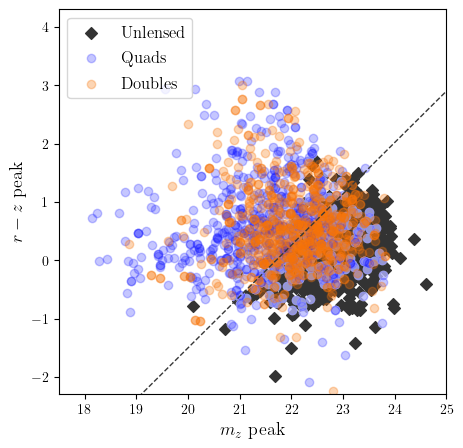

In [719]:
def colour_mag_cut(mz):
    # return mz - 22
    return 0.88 * mz - 19.1

def plot_(xx_label, yy_label, xx, yy, df, savefig=None):
    df_micro_lens_ = df_[df_.nima!=1]
    df_micro_unlen = df_[df_.nima==1]
    df_out_resolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='resolved') ]
    df_out_unresolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='unresolved') ]
    df_out_resolved_nim4   = df_[(df_.nima==4 ) & (df_['type']=='resolved') ]
    df_out_unresolved_nim4 = df_[(df_.nima==4 ) & (df_['type']=='unresolved') ]
    df_doubl = df_lens_doubl[df_detected_doubl]
    df_quads = df_lens_quads[df_detected_quads]

    print(len(df_lens_doubl), len(df_doubl))
    print(len(df_lens_quads), len(df_quads))
    
    ei = 5000
    color_gold = '#e6c700'
    N = 1800
    ri_d = np.random.randint(0, len(df_doubl), size=N)
    ri_q = np.random.randint(0, len(df_quads), size=N)
    
    x_cut = np.linspace(17, 26)
    y_cut = colour_mag_cut(x_cut) #73c7de ed1c38 doubles:00ccaa unlensed:f04158 quads:7d42b8
    # geel:fbc000 darkblue:191dff orange:f87408 green:34c52c
     
    plt.figure(figsize=(5,5))
    plt.scatter(       df_micro_unlen[xx],        df_micro_unlen[yy]  ,alpha=1, color='#333333',marker='D', label='Unlensed')
    #plt.scatter(  df_out_resolved_nim2[xx],   df_out_resolved_nim2[yy]  ,alpha=0.2, color='blue', label='Resolved doubles')
    #plt.scatter(df_out_unresolved_nim2[xx], df_out_unresolved_nim2[yy]  ,alpha=0.2, color='blue',facecolors='none', label='Unresolved doubles')
    #plt.scatter(  df_out_resolved_nim4[xx],   df_out_resolved_nim4[yy]  ,alpha=0.2, color='green', label='Resolved quads')
    #plt.scatter(df_out_unresolved_nim4[xx], df_out_unresolved_nim4[yy]  ,alpha=0.2, color='green',facecolors='none',  label='Unresolved quads')
    plt.scatter(df_quads.iloc[ri_q][xx], df_quads.iloc[ri_q][yy]  ,alpha=0.7, color='white')
    plt.scatter(df_quads.iloc[ri_q][xx], df_quads.iloc[ri_q][yy]  ,alpha=0.25, color='#191dff',  label='Quads')
    plt.scatter(df_doubl.iloc[ri_d][xx], df_doubl.iloc[ri_d][yy]  ,alpha=0.3, color='#f87408',  label='Doubles')
    plt.plot(x_cut, y_cut, '--', color='#383838', lw=1)
    
    print(len(df_doubl[xx]), len(df_quads.iloc[ri_q][xx]))
    
    plt.legend(loc='upper left', fontsize=12)
    plt.xlabel(xx_label, fontsize=13)
    plt.ylabel(yy_label, fontsize=13)
    plt.xlim(17.5, 25)
    plt.ylim(-2.3, 4.3)
    #plt.ylim(-1,3)
    #plt.savefig("../Results/Figures/Results_0506/Colour_magnitude_rz.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
    plt.show()
    
xx_label = r'$m_z$ peak'
yy_label = r'$r-z$ peak'
xx = 'z_peak_mag_micro'
yy = 'r-z_micro'
plot_(xx_label, yy_label, xx, yy, df_[mask_microdet_], savefig='r-z_z.pdf')

### Gold sample on colour-mag plot

In [368]:
df_lens_doubl = df_[df_.nima==2]
df_lens_quads = df_[df_.nima==4]

df_gold_doubl, df_gold_quads = [], []
df_detected_doubl, df_detected_quads = [], []

for i in df_lens_doubl['index']:
    df_gold_doubl.append(gold_d[int(i)])
    df_detected_doubl.append(md_detected_micro[int(i)])
    
for j in df_lens_quads['index']:
    df_gold_quads.append(gold_q[int(j)])
    df_detected_quads.append(mq_detected_micro[int(j)])
    
df_gold_doubl = np.array(df_gold_doubl)
df_gold_quads = np.array(df_gold_quads)
df_detected_doubl = np.array(df_detected_doubl)
df_detected_quads = np.array(df_detected_quads)

print(type(df_gold_doubl))
print(np.shape(df_gold_doubl))
df_gold_doubl

<class 'numpy.ndarray'>
(7844,)


array([False, False, False, ..., False, False, False])

In [392]:
# For Ana

with open('Gold_sample_indices_doubles.pkl','wb') as f:
    pickle.dump(df_gold_doubl, f)
with open('Gold_sample_indices_quads.pkl','wb') as f:
    pickle.dump(df_gold_quads, f)

In [396]:
# Code snippet for Ana

import pickle

with open('Gold_sample_indices_doubles.pkl','rb') as f:
    gold_indices_doubl = pickle.load(f)
with open('Gold_sample_indices_quads.pkl','rb') as f:
    gold_indices_quads = pickle.load(f)

df_lens_doubl = df_[df_.nima==2]
df_lens_quads = df_[df_.nima==4]
df_lens_doubl_gold = df_lens_doubl[gold_indices_doubl]
df_lens_quads_gold = df_lens_quads[gold_indices_quads]


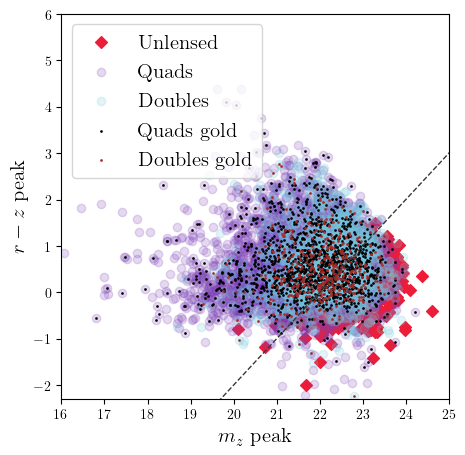

In [278]:
xx_label = r'$m_z$ peak'
yy_label = r'$r-z$ peak'
xx = 'z_peak_mag_micro'
yy = 'r-z_micro'

df_micro_lens_ = df_[df_.nima!=1]
df_micro_unlen = df_[df_.nima==1]
df_out_resolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='resolved') ]
df_out_unresolved_nim2 = df_[(df_.nima==2 ) & (df_['type']=='unresolved') ]
df_out_resolved_nim4   = df_[(df_.nima==4 ) & (df_['type']=='resolved') ]
df_out_unresolved_nim4 = df_[(df_.nima==4 ) & (df_['type']=='unresolved') ]
df_lens_doubl = df_[df_.nima==2]
df_lens_quads = df_[df_.nima==4]
df_lens_doubl_gold = df_lens_doubl[df_gold_doubl]
df_lens_quads_gold = df_lens_quads[df_gold_quads]

ei = 5000
color_gold = '#e6c700'

x_cut = np.linspace(17, 26)
y_cut = colour_mag_cut(x_cut) #73c7de ed1c38

plt.figure(figsize=(5,5))
plt.scatter(       df_micro_unlen[xx][:ei],        df_micro_unlen[yy][:ei]  ,alpha=1, color='#ed1c38',marker='D', label='Unlensed')
#plt.scatter(  df_out_resolved_nim2[xx],   df_out_resolved_nim2[yy]  ,alpha=0.2, color='blue', label='Resolved doubles')
#plt.scatter(df_out_unresolved_nim2[xx], df_out_unresolved_nim2[yy]  ,alpha=0.2, color='blue',facecolors='none', label='Unresolved doubles')
#plt.scatter(  df_out_resolved_nim4[xx],   df_out_resolved_nim4[yy]  ,alpha=0.2, color='green', label='Resolved quads')
#plt.scatter(df_out_unresolved_nim4[xx], df_out_unresolved_nim4[yy]  ,alpha=0.2, color='green',facecolors='none',  label='Unresolved quads')
plt.scatter(df_lens_quads[xx], df_lens_quads[yy]  ,alpha=0.2, color='#7d42b8',  label='Quads')
plt.scatter(df_lens_doubl[xx], df_lens_doubl[yy]  ,alpha=0.2, color='#73c7de',  label='Doubles')
plt.scatter(df_lens_quads_gold[xx], df_lens_quads_gold[yy]  ,alpha=0.9, color='black',  label='Quads gold', s=1)
plt.scatter(df_lens_doubl_gold[xx], df_lens_doubl_gold[yy]  ,alpha=0.9, color='brown',  label='Doubles gold', s=1)
plt.plot(x_cut, y_cut, '--', color='#383838', lw=1)

plt.legend(loc=0, fontsize=15)
plt.xlabel(xx_label, fontsize=15)
plt.ylabel(yy_label, fontsize=15)
plt.xlim(16, 25) #17.5
plt.ylim(-2.3, 6) #4.3
#plt.ylim(-1,3)
# plt.savefig("../Results/Figures/Results_0506/Colour_magnitude_rz_gold.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

### Redshift distributions (lensed and unlensed)

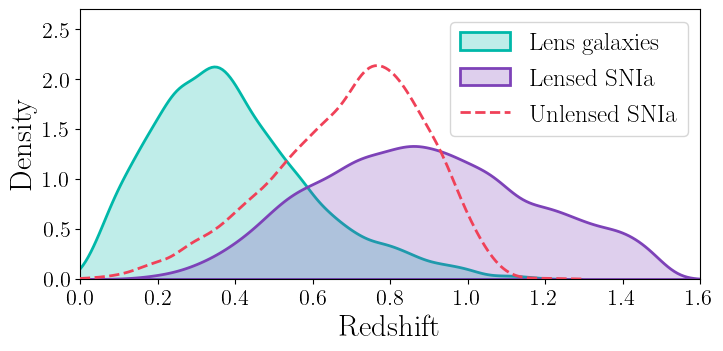

In [741]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
zrange = (0, 1.5)

z_lens_list = list(doubles['z_lens']) + list(quads['z_lens'])
z_source_list = list(doubles['z_source']) + list(quads['z_source'])

# 00b8a9 00bfc9 
# blå: 49c0c4

sns.kdeplot(z_lens_list, ax=ax, lw=2, color="#00b8a9", fill=True, label="Lens galaxies", zorder=1)
sns.kdeplot(z_source_list, ax=ax, lw=2, color="#7d42b8", fill=True, label="Lensed SNIa", zorder=2)
sns.kdeplot(sne['z_source'], ax=ax, lw=2, color="#f04158", fill=False, label="Unlensed SNIa", ls='--', zorder=100)

handles,labels = ax.get_legend_handles_labels()
handles = [handles[1], handles[2], handles[0]]
labels = [labels[1], labels[2], labels[0]]

ax.legend(handles,labels, fontsize=18)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# ax.set_yticks([])
plt.xlim(0, 1.6)
plt.ylim(0, 2.7)
plt.xlabel(r"Redshift", fontsize=22)
plt.ylabel(r"Density", fontsize=22)
plt.savefig("../Results/Figures/Results_0506/z_distributions.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
plt.show()

### Microlensing impact on properties

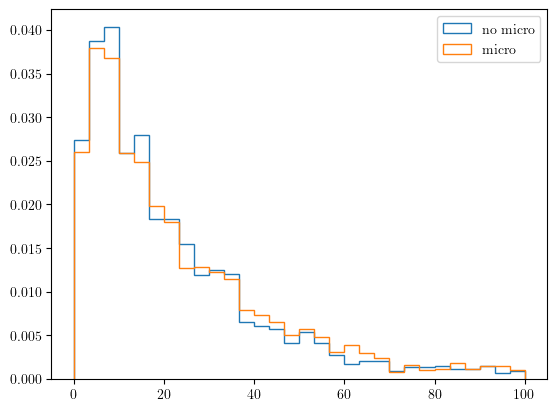

In [650]:
plt.hist(dt_doubles[(md_detected)], histtype='step', bins=30, range=(0,100), label='no micro', density=True)
plt.hist(dt_doubles[(md_detected_micro)], histtype='step', bins=30, range=(0,100), label='micro', density=True)
plt.legend()
plt.show()

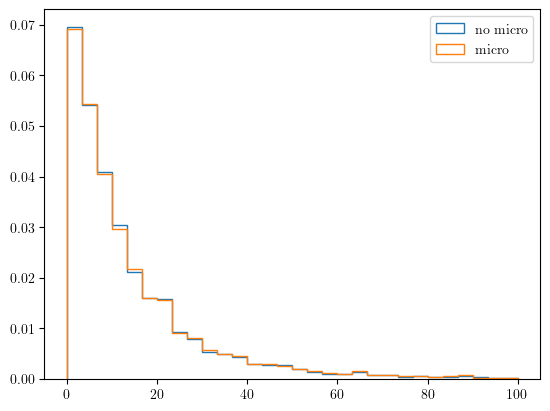

In [651]:
plt.hist(dt_quads[(mq_detected)], histtype='step', bins=30, range=(0,100), label='no micro', density=True)
plt.hist(dt_quads[(mq_detected_micro)], histtype='step', bins=30, range=(0,100), label='micro', density=True)
plt.legend()
plt.show()

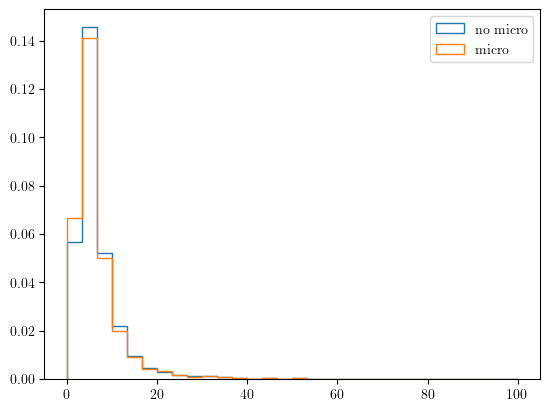

In [653]:
plt.hist(mutot_doubles[(md_detected)], histtype='step', bins=30, range=(0,100), label='no micro', density=True)
plt.hist(mutot_doubles[(md_detected_micro)], histtype='step', bins=30, range=(0,100), label='micro', density=True)
plt.legend()
plt.show()

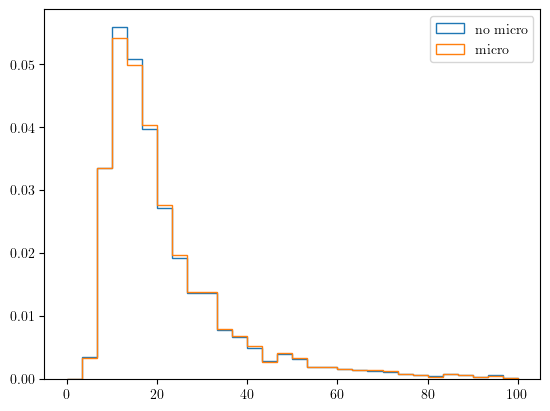

In [654]:
plt.hist(mutot_quads[(mq_detected)], histtype='step', bins=30, range=(0,100), label='no micro', density=True)
plt.hist(mutot_quads[(mq_detected_micro)], histtype='step', bins=30, range=(0,100), label='micro', density=True)
plt.legend()
plt.show()

### Properties of LS4 sample
Limiting magnitude: 21 mag

In [655]:
len(peak_i_doubles)

5000

Sample with i-band peak magnitude < 21
 
Median time delay for LSST sample (doubles, quads):  18.88  ,  9.41  days
Median time delay for LS4 sample (doubles, quads) :  9.84  ,  9.47  days
 
Median magnification for LSST sample (doubles, quads):  4.75  ,  16.53  days
Median magnification for LS4 sample (doubles, quads) :  5.62  ,  16.52  days


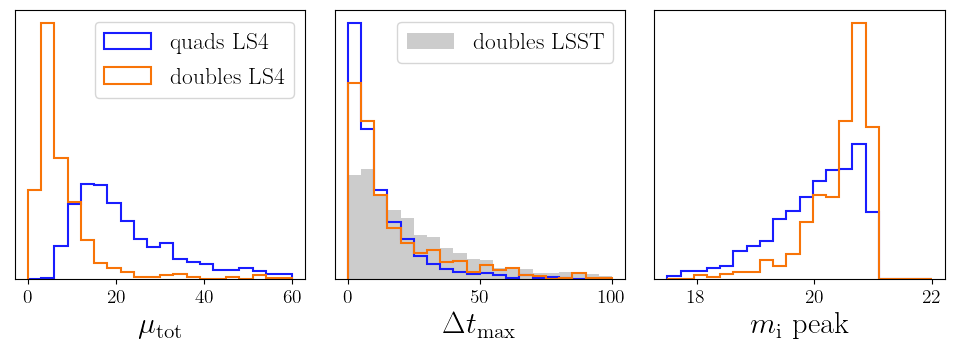

In [698]:

fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
fig.subplots_adjust(wspace=0.1)

properties_d = [mutot_doubles[peak_i_doubles < 21], dt_doubles[peak_i_doubles < 21], 
                peak_i_doubles[peak_i_doubles < 21]]
properties_q = [mutot_quads[peak_i_quads < 21], dt_quads[peak_i_quads < 21], 
                peak_i_quads[peak_i_quads < 21]]
ranges = [(0, 60), (0, 100), (17.5, 22)]
labels = [r'$\mu_{\rm tot}$', r'$\Delta t_{\rm max}$', r'$m_{\rm i}$ peak']
bins = [20, 20, 20]
limits = [np.nan, 10, 22.5]
fill = [np.nan, [-50, 10], [22.5, 25]]
#doubles:00b899 quads:7d42b8

for i in range(3):
    ax[i].hist(properties_q[i], range=ranges[i], histtype='step', lw=1.5, bins=bins[i], density=True, 
               label='quads LS4' if i==0 else None,  color='#191dff')
    ax[i].hist(properties_d[i], range=ranges[i], histtype='step', lw=1.5, bins=bins[i], density=True, 
               label='doubles LS4' if i==0 else None, color='#f87408')
    ax[i].set_xlabel(labels[i], fontsize=22)
    ax[i].xaxis.set_tick_params(labelsize=14)
    ax[i].set_yticks([])
    ymin, ymax = ax[i].get_ylim()
    xmin, xmax = ax[i].get_xlim()
        
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(ymin, ymax)

ax[0].legend(fontsize=17)
ax[1].hist(dt_doubles, range=(0, 100), bins=bins[i], density=True, label='doubles LSST', color='black', alpha=0.2)
# plt.savefig("../Results/Figures/Results_0506/Properties_LS4_21mag.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')
ax[1].legend(fontsize=17)

print("Sample with i-band peak magnitude < 21")
print(" " )
print("Median time delay for LSST sample (doubles, quads): ", np.around(np.median(dt_doubles), 2), " , ",
     np.around(np.median(dt_quads), 2), " days")
print("Median time delay for LS4 sample (doubles, quads) : ", np.around(np.median(dt_doubles[peak_i_doubles < 21]), 2), 
      " , ", np.around(np.median(dt_quads[peak_i_doubles < 21]), 2), " days")

print(" ")
print("Median magnification for LSST sample (doubles, quads): ", np.around(np.median(mutot_doubles), 2), " , ",
     np.around(np.median(mutot_quads), 2), " days")
print("Median magnification for LS4 sample (doubles, quads) : ", np.around(np.median(mutot_doubles[peak_i_doubles < 21]), 2), 
      " , ", np.around(np.median(mutot_quads[peak_i_doubles < 21]), 2), " days")

# plt.savefig("../Results/Figures/LS4_properties.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

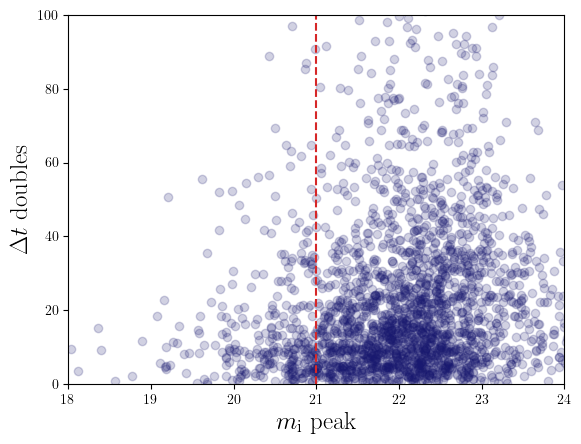

In [699]:
plt.scatter(peak_i_doubles[md_detected], dt_doubles[md_detected], alpha=0.2, color='Midnightblue')
plt.ylim(0, 100)
plt.xlim(18, 24)
plt.xlabel(r'$m_{\rm i}$ peak', fontsize=18)
plt.ylabel(r'$\Delta t$ doubles', fontsize=18)
plt.axvline(x=21, ls='--', color='C3')

#plt.savefig("../Results/Figures/LS4_dt_mi.png", transparent=False, facecolor='white', dpi=250, bbox_inches='tight')

In [695]:
md_LS4 = peak_i_doubles < 21
mq_LS4 = peak_i_quads < 21

In [697]:
print("WFD (based on simple scaling 20,000 >> 18,000)")
print(" ")

# Yearly predicted rates by Wojtak et al.

rates_total = 89 * 3
fraction_quads = 0.28
fraction_doubles = 0.72
rates_quads = rates_total * fraction_quads
rates_doubles = rates_total * fraction_doubles

sd2 = rates_doubles / ((md_WFD) & (md_detected_peak)).sum() / 1.5 /20000 * 18000
sq2 = rates_quads / ((mq_WFD) & (mq_detected_peak)).sum() / 1.5 /20000 * 18000

print("--- Doubles ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((md_WFD) & (md_detected_peak) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_peak) & (md_rol)).sum()*sd2)
print("N detected  :     ",  ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N detected micro: ",  ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("dt > 10 :         ",  ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_dt_lim) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("Gold sample :     ",  ((gold_d) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((gold_d) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("LS4 (< 21 mag) :  ",  ((md_LS4) & (md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((md_LS4) & (md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)

print(" ")

print("--- Quads ---")
print("             Non-rolling    ---    Rolling")
print("N detected peak:  ",  ((mq_WFD) & (mq_detected_peak) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_peak) & (mq_rol)).sum()*sq2)
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2)
print("N detected micro: ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("dt > 10           ",  ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_dt_lim) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("Gold sample :     ",  ((gold_q) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((gold_q) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)
print("LS4 (< 21 mag) :  ",  ((mq_LS4) & (mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2,"    ", 
                            ((mq_LS4) & (mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2)

print(" ")

print("--- Total ---")
print("             Non-rolling    ---    Rolling")
print("without microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected)).sum()*sd2 + ((mq_WFD) & (mq_detected)).sum()*sq2)/2)
print(" ")

print("with microlensing:")
print("N detected  :     ",  ((mq_WFD) & (mq_detected_micro) & (mq_nonrol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol)).sum()*sd2)
print("N with time delay > 10 days : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (md_dt_lim)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (mq_dt_lim)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (md_dt_lim)).sum()*sd2)
print("N in Gold sample  : ", ((mq_WFD) & (mq_detected_micro) & (mq_nonrol) & (gold_q)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_nonrol) & (gold_d)).sum()*sd2,"    ", 
                            ((mq_WFD) & (mq_detected_micro) & (mq_rol) & (gold_q)).sum()*sq2 + ((md_WFD) & (md_detected_micro) & (md_rol) & (gold_d)).sum()*sd2)


print(" ")
print("Total N of lensed SNe: ", (((md_WFD) & (md_detected_micro)).sum()*sd2 + ((mq_WFD) & (mq_detected_micro)).sum()*sq2)/2)

WFD (based on simple scaling 20,000 >> 18,000)
 
--- Doubles ---
             Non-rolling    ---    Rolling
N detected peak:   58.098946994373705      57.245053005626296
N detected  :      35.48783417234232      30.979273911755996
N detected micro:  32.27719277465206      27.187984601717503
dt > 10 :          21.723063073734085      18.444110156944035
Gold sample :      8.197382291975126      6.318815516730826
LS4 (< 21 mag) :   4.167002665087356      4.645183298785905
 
--- Quads ---
             Non-rolling    ---    Rolling
N detected peak:   22.385625910931175      22.470374089068827
N detected  :      18.24507206477733      17.252307692307692
N detected micro:  17.39759028340081      16.27165020242915
dt > 10            7.893687449392713      7.772618623481782
Gold sample :      4.673256680161944      3.910523076923077
LS4 (< 21 mag) :   10.097140080971661      10.000285020242917
 
--- Total ---
             Non-rolling    ---    Rolling
without microlensing:
N detected  :      53

(array([0.51268905, 0.98251664, 1.15890805, 1.20176952, 1.05175439,
        0.88690261, 0.6742438 , 0.53247127, 0.43191168, 0.25716879,
        0.17474289, 0.12199032, 0.09066848, 0.05275257, 0.02143073,
        0.0181337 , 0.01978221, 0.01153962, 0.0181337 , 0.00329704,
        0.00329704, 0.00329704, 0.00164852, 0.        , 0.00164852,
        0.00164852, 0.00164852, 0.00329704, 0.        , 0.00329704]),
 array([0.0503251 , 0.1716462 , 0.29296731, 0.41428841, 0.53560951,
        0.65693061, 0.77825171, 0.89957281, 1.02089391, 1.14221501,
        1.26353611, 1.38485721, 1.50617831, 1.62749941, 1.74882051,
        1.87014161, 1.99146271, 2.11278381, 2.23410491, 2.35542601,
        2.47674711, 2.59806821, 2.71938931, 2.84071041, 2.96203151,
        3.08335261, 3.20467371, 3.32599481, 3.44731591, 3.56863701,
        3.68995811]),
 [<matplotlib.patches.Polygon at 0x7fb3a7e26dd8>])

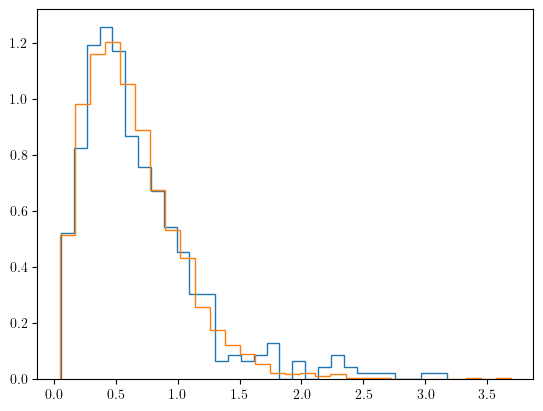

In [704]:
plt.hist(doubles['theta_E'][md_LS4], histtype='step', bins=30, density=True)
plt.hist(doubles['theta_E'], histtype='step', bins=30, density=True)